In [1]:
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math
import pickle
from tqdm import tqdm_notebook
from multiprocessing import Pool

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from rangerlars import RangerLars

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

In [3]:
torch.cuda.set_device(1)

## Parameters Setting

In [211]:
#
# Classifier
# ---------------------
## focal loss
alpha = 1
gamma_pos = 6
gamma_neg = 2
grad_clip = 1
lambda_l1 = 0
weight_decay = 0   # lambda_l2

#
# VAT
# ---------------------
vat_xi = 1e-6
vat_eps_pos = 1e2
vat_eps_neg = 1e-1
vat_ip = 1

#
# Training process
# ---------------------
train_batch_size = 128
test_batch_size = 32

#
# Optimizer
# ---------------------
optim_type = 'rlars'       # ['adam', 'rlars']
learn_rate = 1e-4
adam_beta1 = 0.9
adam_beta2 = 0.999

max_epochs = 1600

## Model Declaration

### Conv1D

In [214]:
class ConvNet(nn.Module):
    def __init__(self, fc_dims, in_dim=256, out_dim=1):
        super(ConvNet, self).__init__()
        
        self.in_dim = in_dim
        self.conv1_dim = math.ceil(self.in_dim)
        self.conv2_dim = math.ceil(self.in_dim * 2)
        self.conv3_dim = math.ceil(self.in_dim)
        self.outdim_en1 = fc_dims[0]
        self.outdim_en2 = fc_dims[1]
        self.out_dim = out_dim
        
        self.model_conv = nn.Sequential(
            nn.Conv1d(in_channels=in_dim, out_channels=self.conv1_dim, kernel_size=2),
            nn.BatchNorm1d(self.conv1_dim),
            nn.ReLU(),
            nn.Conv1d(in_channels=self.conv1_dim, out_channels=self.conv2_dim, kernel_size=2),
            nn.BatchNorm1d(self.conv2_dim),
            nn.ReLU(),
            nn.Conv1d(in_channels=self.conv2_dim, out_channels=self.conv3_dim, kernel_size=2),
            nn.BatchNorm1d(self.conv3_dim),
            nn.ReLU(),
        )
        dropout_1 = 1 - 0.1
        dropout_2 = 1 - 0.2
        dropout_3 = 1 - 0.2
        self.model_fc = nn.Sequential(
            # FC 1
            nn.Dropout(dropout_1),
            nn.Linear(in_features=self.conv3_dim, out_features=self.outdim_en1),
            nn.BatchNorm1d(self.outdim_en1),
            nn.ReLU(),
            # FC 2
            nn.Dropout(dropout_2),
            nn.Linear(in_features=self.outdim_en1, out_features=self.outdim_en2),
            nn.BatchNorm1d(self.outdim_en2),
            nn.ReLU(),
            # FC 3
            nn.Dropout(dropout_3),
            nn.Linear(in_features=self.outdim_en2, out_features=self.out_dim),
            nn.Sigmoid()
        )
        
        print("conv_dim = [{}, {}, {}]".format(self.conv1_dim, self.conv2_dim, self.conv3_dim))
        print("fc_dim = [{}/{}, {}/{}, {}/{}, {}]".format(self.conv3_dim, dropout_1, 
                                                          self.outdim_en1, dropout_2, 
                                                          self.outdim_en2, dropout_3, self.out_dim))
        
    def forward(self, x):
        x = self.model_conv(x)
        x = self.model_fc(x.view(x.shape[0], -1))
        return x
    
    def get_trainable_parameters(self):
        return (param for param in self.parameters() if param.requires_grad)

### Focal Loss

In [215]:
class FocalLoss2(nn.Module):
    def __init__(self, alpha=0.01, gamma_pos=3, gamma_neg=2, logits=False, reduce=True):
        super(FocalLoss2, self).__init__()
        self.alpha = alpha
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.logits = logits
        self.reduce = reduce
    
    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        gamma_diff = self.gamma_pos - self.gamma_neg
        F_loss_pos = self.alpha * targets * (1-pt)**self.gamma_pos * BCE_loss
        F_loss_pos = torch.mean(pt)**(-gamma_diff) * F_loss_pos
        F_loss_neg = self.alpha * (1 - targets) * (1-pt)**self.gamma_neg * BCE_loss
        F_loss = 1 * F_loss_pos + 0.9 * F_loss_neg
        
        avg_F_loss_pos = torch.sum(F_loss_pos) / torch.sum(targets)
        avg_F_loss_neg = torch.sum(F_loss_neg) / torch.sum(1-targets)
        
        if self.reduce:
            return torch.mean(F_loss), avg_F_loss_pos, avg_F_loss_neg
        else:
            return F_loss, F_loss_pos, F_loss_neg

## Virtual Adversarial Training

In [216]:
import contextlib


@contextlib.contextmanager
def _disable_tracking_bn_stats(model):

    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
            
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)

    
def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
    return d


class VATLoss2(nn.Module):

    def __init__(self, xi=1e-6, eps_pos=100, eps_neg=1., ip=1):
        """VAT loss
        :param xi: hyperparameter of VAT (default: 10.0)
        :param eps_pos: hyperparameter of VAT (default: 100.0)
        :param eps_neg: hyperparameter of VAT (default: 0.1)
        :param ip: iteration times of computing adv noise (default: 1)
        """
        super(VATLoss2, self).__init__()
        self.xi = xi
        self.eps_pos = eps_pos
        self.eps_neg = eps_neg
        self.ip = ip

    def forward(self, model, x, y):
        with torch.no_grad():
            pred = F.softmax(model(x), dim=1)

        # Prepare random unit tensor
        d = torch.rand(x.shape).sub(0.5).to(x.device)
        d = _l2_normalize(d)

        with _disable_tracking_bn_stats(model):
            # Calculate adversarial direction
            for _ in range(self.ip):
                d.requires_grad_()
                pred_hat = model(x + self.xi * d)
                logp_hat = F.log_softmax(pred_hat, dim=1)
                # adv_distance = F.kl_div(logp_hat, pred, reduction='batchmean')  # for PyTorch v1.0
                adv_distance = F.kl_div(logp_hat, pred)                           # for PyTorch v0.4
                adv_distance.backward()
                d = _l2_normalize(d.grad)
                model.zero_grad()
    
            # calc LDS
            r_adv = d * (self.eps_pos * y + self.eps_neg * (1-y)).reshape(-1, 1, 1)
            pred_hat = model(x + r_adv)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            # lds = F.kl_div(logp_hat, pred, reduction='batchmean')  # for PyTorch v1.0
            lds = F.kl_div(logp_hat, pred)                           # for PyTorch v1.0

        return lds

## Data Preparation

### Training / Testing partition setting

In [205]:
training_date  = [(2018, 7), (2018, 8), (2018, 9),(2018, 10), (2018, 11), (2018, 12)]
testing_date   = [(2019, 1), (2019, 2), (2019, 3), (2019, 4), (2019, 5), (2019, 6)]

### Data loading

In [206]:
data = dict(map(lambda ym: (ym, 
                            np.load('../../user_data/CloudMile/data/data_{}_{}.npz'.format(*ym), allow_pickle=True)), 
                training_date + testing_date))

In [207]:
train_data = list(map(lambda ym: data[ym], training_date))
test_data = list(map(lambda ym: data[ym], testing_date))

X_train_ = np.concatenate([data['arr_0'] for data in train_data])
y_train_ = np.concatenate([data['arr_1'] for data in train_data])
training_announce = np.concatenate([data['arr_2'] for data in train_data])
training_FILTER = np.concatenate([data['arr_3'] for data in train_data])

X_test_ = np.concatenate([data['arr_0'] for data in test_data])
y_test_ = np.concatenate([data['arr_1'] for data in test_data])
testing_announce = np.concatenate([data['arr_2'] for data in test_data])
testing_FILTER = np.concatenate([data['arr_3'] for data in test_data])

### Extracting announced data

In [208]:
X_train = X_train_[training_announce == 1]
y_train = y_train_[training_announce == 1]

X_test = X_test_[testing_announce == 1]
y_test = y_test_[testing_announce == 1]

### Magical rescaling

In [209]:
X_train[:,:,0] = 0.1 * np.log10(1e4*X_train[:,:,0]**3 + 1e-10) + 1
X_train[:,:,2] = 0.1 * np.log10(1e4*X_train[:,:,2]**5 + 1e-10) + 1
X_train[:,:,3] = 0.1 * np.log10(1e4*X_train[:,:,3]**2 + 1e-10) + 1
X_train[:,:,6] = 0.1 * np.log10(1e0*X_train[:,:,6]**3 + 1e-10) + 1
X_train[:,:,7] = 0.1 * np.log10(1e8*X_train[:,:,7]**5 + 1e-10) + 1
X_train[:,:,8] = 0.1 * np.log10(1e8*X_train[:,:,8]**3 + 1e-10) + 1
X_train[:,:,9] = 0.1 * np.log10(1e8*X_train[:,:,9]**6 + 1e-10) + 1
X_train[:,:,10] = 0.1 * np.log10(1e8*X_train[:,:,10]**2 + 1e-10) + 1
X_train[:,:,12] = 0.1 * np.log10(1e9*X_train[:,:,12]**3 + 1e-10) + 1
X_train[:,:,13] = 0.1 * np.log10(1e9*X_train[:,:,13]**5 + 1e-10) + 1
X_train[:,:,14] = 0.1 * np.log10(1e9*X_train[:,:,14]**3.5 + 1e-10) + 1
X_train[:,:,15] = 0.1 * np.log10(1e9*X_train[:,:,15]**6 + 1e-10) + 1
X_train[:,:,16] = 0.1 * np.log10(1e15*X_train[:,:,16]**3 + 1e-10) + 1
X_train[:,:,18] = 0.1 * np.log10(1e15*X_train[:,:,18]**4 + 1e-10) + 1
X_train[:,:,20] = 0.1 * np.log10(1e10*X_train[:,:,20]**8 + 1e-10) + 1
X_train[:,:,21] = 0.1 * np.log10(1e8*X_train[:,:,21]**3 + 1e-10) + 1
X_train[:,:,22] = 0.1 * np.log10(1e20*X_train[:,:,22]**4 + 1e-10) + 1
X_train[:,:,23] = 0.1 * np.log10(1e20*X_train[:,:,23]**4 + 1e-10) + 1
X_train[:,:,24] = 0.1 * np.log10(1e10*X_train[:,:,24]**5 + 1e-10) + 1
X_train[:,:,26] = 0.1 * np.log10(1e10*X_train[:,:,26]**7 + 1e-10) + 1
X_train[:,:,27] = 0.1 * np.log10(1e10*X_train[:,:,27]**3 + 1e-10) + 1
X_train[:,:,29] = 0.1 * np.log10(1e10*X_train[:,:,29]**7 + 1e-10) + 1
X_train[:,:,30] = 0.1 * np.log10(1e10*X_train[:,:,30]**3 + 1e-10) + 1
X_train[:,:,32] = 0.1 * np.log10(1e10*X_train[:,:,32]**3 + 1e-10) + 1
X_train[:,:,33] = 0.1 * np.log10(1e10*X_train[:,:,33]**2.5 + 1e-10) + 1
X_train[:,:,34] = 0.1 * np.log10(1e10*X_train[:,:,34]**3 + 1e-10) + 1
X_train[:,:,35] = 0.1 * np.log10(1e20*X_train[:,:,35]**4 + 1e-10) + 1
X_train[:,:,36] = 0.1 * np.log10(1e18*X_train[:,:,36]**5 + 1e-10) + 1
X_train[:,:,37] = 0.1 * np.log10(1e20*X_train[:,:,37]**4 + 1e-10) + 1
X_train[:,:,38] = 0.1 * np.log10(1e20*X_train[:,:,38]**3 + 1e-10) + 1
X_train[:,:,39] = 0.1 * np.log10(1e20*X_train[:,:,39]**3 + 1e-10) + 1
X_train[:,:,40] = 0.1 * np.log10(1e20*X_train[:,:,40]**3 + 1e-10) + 1
X_train[:,:,41] = 0.1 * np.log10(1e20*X_train[:,:,41]**3 + 1e-10) + 1
X_train[:,:,42] = 0.1 * np.log10(1e20*X_train[:,:,42]**3 + 1e-10) + 1
X_train[:,:,43] = 0.1 * np.log10(1e20*X_train[:,:,43]**3 + 1e-10) + 1
X_train[:,:,44] = 0.1 * np.log10(1e20*X_train[:,:,44]**3 + 1e-10) + 1
X_train[:,:,45] = 0.1 * np.log10(1e20*X_train[:,:,45]**3 + 1e-10) + 1
X_train[:,:,46] = 0.1 * np.log10(1e20*X_train[:,:,46]**3 + 1e-10) + 1
X_train[:,:,47] = 0.1 * np.log10(1e20*X_train[:,:,47]**3 + 1e-10) + 1
X_train[:,:,51] = 0.1 * np.log10(1e20*X_train[:,:,51]**3 + 1e-10) + 1
X_train[:,:,52] = 0.1 * np.log10(1e20*X_train[:,:,52]**3 + 1e-10) + 1
X_train[:,:,53] = 0.1 * np.log10(1e20*X_train[:,:,53]**3 + 1e-10) + 1
X_train[:,:,54] = 0.1 * np.log10(1e20*X_train[:,:,54]**3 + 1e-10) + 1
X_train[:,:,57] = 0.1 * np.log10(1e20*X_train[:,:,57]**20 + 1e-10) + 1
X_train[:,:,58] = 0.1 * np.log10(1e20*X_train[:,:,58]**10 + 1e-10) + 1
X_train[:,:,59] = 0.1 * np.log10(1e20*X_train[:,:,59]**8 + 1e-10) + 1
X_train[:,:,60] = 0.1 * np.log10(1e20*X_train[:,:,60]**6 + 1e-10) + 1
X_train[:,:,61] = 0.1 * np.log10(1e20*X_train[:,:,61]**6 + 1e-10) + 1
X_train[:,:,62] = 0.1 * np.log10(1e20*X_train[:,:,62]**5 + 1e-10) + 1
X_train[:,:,63] = 0.1 * np.log10(1e20*X_train[:,:,63]**3 + 1e-10) + 1
X_train[:,:,64] = 0.1 * np.log10(1e20*X_train[:,:,64]**3 + 1e-10) + 1
X_train[:,:,65] = 0.1 * np.log10(1e20*X_train[:,:,65]**3 + 1e-10) + 1
X_train[:,:,66] = 0.1 * np.log10(1e20*X_train[:,:,66]**3 + 1e-10) + 1
X_train[:,:,67] = 0.1 * np.log10(1e20*X_train[:,:,67]**1.5 + 1e-10) + 1
X_train[:,:,68] = 0.1 * np.log10(1e20*X_train[:,:,68]**1.5 + 1e-10) + 1
X_train[:,:,69] = 0.1 * np.log10(1e20*X_train[:,:,69]**1.5 + 1e-10) + 1
X_train[:,:,70] = 0.1 * np.log10(1e20*X_train[:,:,70]**1.5 + 1e-10) + 1
X_train[:,:,71] = 0.1 * np.log10(1e20*X_train[:,:,71]**3 + 1e-10) + 1
X_train[:,:,72] = 0.1 * np.log10(1e20*X_train[:,:,72]**3 + 1e-10) + 1
X_train[:,:,73] = 0.1 * np.log10(1e20*X_train[:,:,73]**3 + 1e-10) + 1
X_train[:,:,74] = 0.1 * np.log10(1e20*X_train[:,:,74]**3 + 1e-10) + 1
X_train[:,:,75] = 0.1 * np.log10(1e20*X_train[:,:,75]**3 + 1e-10) + 1
X_train[:,:,76] = 0.1 * np.log10(1e20*X_train[:,:,76]**3 + 1e-10) + 1
X_train[:,:,77] = 0.1 * np.log10(1e15*X_train[:,:,77]**8 + 1e-10) + 1
X_train[:,:,78] = 0.1 * np.log10(1e15*X_train[:,:,78]**8 + 1e-10) + 1
X_train[:,:,79] = 0.1 * np.log10(1e20*X_train[:,:,79]**5 + 1e-10) + 1
X_train[:,:,80] = 0.1 * np.log10(1e20*X_train[:,:,80]**6 + 1e-10) + 1
X_train[:,:,81] = 0.1 * np.log10(1e20*X_train[:,:,81]**8 + 1e-10) + 1
X_train[:,:,82] = 0.1 * np.log10(1e20*X_train[:,:,82]**10 + 1e-10) + 1
X_train[:,:,83] = 0.1 * np.log10(1e20*X_train[:,:,83]**9.5 + 1e-10) + 1
X_train[:,:,84] = 0.1 * np.log10(1e20*X_train[:,:,84]**9.5 + 1e-10) + 1
X_train[:,:,85] = 0.1 * np.log10(1e20*X_train[:,:,85]**3 + 1e-10) + 1
X_train[:,:,86] = 0.1 * np.log10(1e20*X_train[:,:,86]**13 + 1e-10) + 1
X_train[:,:,87] = 0.1 * np.log10(1e20*X_train[:,:,87]**10 + 1e-10) + 1
X_train[:,:,88] = 0.1 * np.log10(1e20*X_train[:,:,88]**9 + 1e-10) + 1
X_train[:,:,89] = 0.1 * np.log10(1e20*X_train[:,:,89]**8 + 1e-10) + 1
X_train[:,:,91] = X_train[:,:,91] ** 5
X_train[:,:,93] = X_train[:,:,93] ** 2
X_train[:,:,94] = X_train[:,:,94] ** 2
X_train[:,:,96] = 0.1 * np.log10(1e20*X_train[:,:,96]**4 + 1e-10) + 1
X_train[:,:,97] = 0.1 * np.log10(1e20*X_train[:,:,97]**9 + 1e-10) + 1
X_train[:,:,98] = 0.1 * np.log10(1e20*X_train[:,:,98]**8 + 1e-10) + 1
X_train[:,:,99] = 0.1 * np.log10(1e20*X_train[:,:,99]**7 + 1e-10) + 1
X_train[:,:,100] = 0.1 * np.log10(1e20*X_train[:,:,100]**7 + 1e-10) + 1
X_train[:,:,101] = 0.1 * np.log10(1e20*X_train[:,:,101]**5 + 1e-10) + 1
X_train[:,:,102] = 0.1 * np.log10(1e20*X_train[:,:,102]**4 + 1e-10) + 1
X_train[:,:,103] = 0.1 * np.log10(1e20*X_train[:,:,103]**4 + 1e-10) + 1
X_train[:,:,104] = 0.1 * np.log10(1e20*X_train[:,:,104]**10 + 1e-10) + 1
X_train[:,:,106] = 0.1 * np.log10(1e20*X_train[:,:,106]**4 + 1e-10) + 1
X_train[:,:,107] = 0.1 * np.log10(1e20*X_train[:,:,107]**8 + 1e-10) + 1
X_train[:,:,108] = 0.1 * np.log10(1e20*X_train[:,:,108]**7 + 1e-10) + 1
X_train[:,:,109] = 0.1 * np.log10(1e20*X_train[:,:,109]**7 + 1e-10) + 1
X_train[:,:,110] = 0.1 * np.log10(1e20*X_train[:,:,110]**7 + 1e-10) + 1
X_train[:,:,111] = 0.1 * np.log10(1e20*X_train[:,:,111]**6 + 1e-10) + 1
X_train[:,:,112] = 0.1 * np.log10(1e20*X_train[:,:,112]**5 + 1e-10) + 1
X_train[:,:,113] = 0.1 * np.log10(1e20*X_train[:,:,113]**5 + 1e-10) + 1
X_train[:,:,114] = 0.1 * np.log10(1e20*X_train[:,:,114]**8 + 1e-10) + 1
X_train[:,:,115] = 0.1 * np.log10(1e20*X_train[:,:,115]**7 + 1e-10) + 1
X_train[:,:,116] = 0.1 * np.log10(1e20*X_train[:,:,116]**6 + 1e-10) + 1
X_train[:,:,117] = 0.1 * np.log10(1e20*X_train[:,:,117]**6 + 1e-10) + 1
X_train[:,:,118] = 0.1 * np.log10(1e20*X_train[:,:,118]**5.5 + 1e-10) + 1
X_train[:,:,119] = 0.1 * np.log10(1e20*X_train[:,:,119]**4 + 1e-10) + 1
X_train[:,:,124] = 0.1 * np.log10(1e20*X_train[:,:,124]**6 + 1e-10) + 1
X_train[:,:,125] = 0.1 * np.log10(1e20*X_train[:,:,125]**7.5 + 1e-10) + 1
X_train[:,:,126] = 0.1 * np.log10(1e20*X_train[:,:,126]**11 + 1e-10) + 1
X_train[:,:,127] = 0.1 * np.log10(1e20*X_train[:,:,127]**8 + 1e-10) + 1
X_train[:,:,128] = 0.1 * np.log10(1e20*X_train[:,:,128]**8 + 1e-10) + 1
X_train[:,:,129] = 0.1 * np.log10(1e20*X_train[:,:,129]**8 + 1e-10) + 1
X_train[:,:,130] = 0.1 * np.log10(1e20*X_train[:,:,130]**8 + 1e-10) + 1
X_train[:,:,132] = 0.1 * np.log10(1e12*X_train[:,:,132]**12 + 1e-10) + 1
X_train[:,:,133] = 0.1 * np.log10(1e20*X_train[:,:,133]**5.5 + 1e-10) + 1
X_train[:,:,140] = 0.1 * np.log10(1e20*X_train[:,:,140]**4 + 1e-10) + 1
X_train[:,:,141] = 0.1 * np.log10(1e20*X_train[:,:,141]**4 + 1e-10) + 1
X_train[:,:,142] = 0.1 * np.log10(1e20*X_train[:,:,142]**4 + 1e-10) + 1
X_train[:,:,143] = 0.1 * np.log10(1e20*X_train[:,:,143]**4 + 1e-10) + 1
X_train[:,:,144] = 0.1 * np.log10(1e20*X_train[:,:,144]**10 + 1e-10) + 1
X_train[:,:,146] = 0.1 * np.log10(1e20*X_train[:,:,146]**10 + 1e-10) + 1
X_train[:,:,147] = 0.1 * np.log10(1e20*X_train[:,:,147]**9 + 1e-10) + 1
X_train[:,:,148] = 0.1 * np.log10(1e20*X_train[:,:,148]**8.5 + 1e-10) + 1
X_train[:,:,149] = 0.1 * np.log10(1e20*X_train[:,:,149]**9 + 1e-10) + 1
X_train[:,:,150] = 0.1 * np.log10(1e20*X_train[:,:,150]**7.5 + 1e-10) + 1
X_train[:,:,151] = 0.1 * np.log10(1e20*X_train[:,:,151]**12 + 1e-10) + 1
X_train[:,:,152] = 0.1 * np.log10(1e20*X_train[:,:,152]**20 + 1e-10) + 1
X_train[:,:,153] = 0.1 * np.log10(1e20*X_train[:,:,153]**11 + 1e-10) + 1
X_train[:,:,154] = 0.1 * np.log10(1e20*X_train[:,:,154]**20 + 1e-10) + 1
X_train[:,:,155] = 0.1 * np.log10(1e20*X_train[:,:,155]**16 + 1e-10) + 1
X_train[:,:,156] = 0.1 * np.log10(1e20*X_train[:,:,156]**10 + 1e-10) + 1
X_train[:,:,157] = 0.1 * np.log10(1e20*X_train[:,:,157]**11 + 1e-10) + 1
X_train[:,:,158] = 0.1 * np.log10(1e20*X_train[:,:,158]**9 + 1e-10) + 1
X_train[:,:,159] = 0.1 * np.log10(1e20*X_train[:,:,159]**3.5 + 1e-10) + 1
X_train[:,:,160] = 0.1 * np.log10(1e20*X_train[:,:,160]**11 + 1e-10) + 1
X_train[:,:,166] = 0.1 * np.log10(1e20*X_train[:,:,166]**11 + 1e-10) + 1
X_train[:,:,168] = 0.1 * np.log10(1e20*X_train[:,:,168]**14 + 1e-10) + 1
X_train[:,:,173] = 0.1 * np.log10(1e30*X_train[:,:,173]**7 + 1e-10) + 1
X_train[:,:,174] = 0.1 * np.log10(1e30*X_train[:,:,174]**4 + 1e-10) + 1
X_train[:,:,178] = 0.1 * np.log10(1e30*X_train[:,:,178]**4 + 1e-10) + 1
X_train[:,:,179] = 0.1 * np.log10(1e30*X_train[:,:,179]**4 + 1e-10) + 1
X_train[:,:,181] = 0.1 * np.log10(1e30*X_train[:,:,181]**7 + 1e-10) + 1
X_train[:,:,182] = 0.1 * np.log10(1e30*X_train[:,:,182]**2 + 1e-10) + 1
X_train[:,:,183] = 0.1 * np.log10(1e30*X_train[:,:,183]**2 + 1e-10) + 1
X_train[:,:,185] = 0.1 * np.log10(1e30*X_train[:,:,185]**2 + 1e-10) + 1
X_train[:,:,186] = 0.1 * np.log10(1e30*X_train[:,:,186]**2 + 1e-10) + 1
X_train[:,:,187] = 0.1 * np.log10(1e30*X_train[:,:,187]**2 + 1e-10) + 1
X_train[:,:,190] = 0.1 * np.log10(1e10*X_train[:,:,190]**4 + 1e-10) + 1
X_train[:,:,191] = 0.1 * np.log10(1e20*X_train[:,:,191]**6 + 1e-10) + 1
X_train[:,:,192] = 0.1 * np.log10(1e20*X_train[:,:,192]**4 + 1e-10) + 1
X_train[:,:,195] = 0.1 * np.log10(1e20*X_train[:,:,195]**4 + 1e-10) + 1
X_train[:,:,196] = 0.1 * np.log10(1e20*X_train[:,:,196]**6 + 1e-10) + 1
X_train[:,:,197] = 0.1 * np.log10(1e20*X_train[:,:,197]**4 + 1e-10) + 1
X_train[:,:,198] = 0.1 * np.log10(1e20*X_train[:,:,198]**6 + 1e-10) + 1
X_train[:,:,200] = 0.1 * np.log10(1e20*X_train[:,:,200]**6 + 1e-10) + 1
X_train[:,:,201] = 0.1 * np.log10(1e20*X_train[:,:,201]**5 + 1e-10) + 1
X_train[:,:,202] = 0.1 * np.log10(1e20*X_train[:,:,202]**5 + 1e-10) + 1
X_train[:,:,203] = 0.1 * np.log10(1e20*X_train[:,:,203]**5 + 1e-10) + 1
X_train[:,:,204] = 0.1 * np.log10(1e30*X_train[:,:,204]**3 + 1e-10) + 1
X_train[:,:,205] = 0.1 * np.log10(1e30*X_train[:,:,205]**3 + 1e-10) + 1
X_train[:,:,206] = 0.1 * np.log10(1e20*X_train[:,:,206]**7 + 1e-10) + 1
X_train[:,:,207] = 0.1 * np.log10(1e30*X_train[:,:,207]**2 + 1e-10) + 1
X_train[:,:,208] = 0.1 * np.log10(1e30*X_train[:,:,208]**2 + 1e-10) + 1
X_train[:,:,209] = 0.1 * np.log10(1e30*X_train[:,:,209]**2 + 1e-10) + 1
X_train[:,:,213] = 0.1 * np.log10(1e30*X_train[:,:,213]**2 + 1e-10) + 1
X_train[:,:,214] = 0.1 * np.log10(1e7*X_train[:,:,214]**2 + 1e-10) + 1
X_train[:,:,215] = 0.1 * np.log10(1e15*X_train[:,:,215]**2 + 1e-10) + 1
X_train[:,:,216] = 0.1 * np.log10(1e15*X_train[:,:,216]**2 + 1e-10) + 1
X_train[:,:,217] = 0.1 * np.log10(1e15*X_train[:,:,217]**2 + 1e-10) + 1
X_train[:,:,218] = 0.1 * np.log10(1e15*X_train[:,:,218]**2 + 1e-10) + 1
X_train[:,:,220] = 0.1 * np.log10(1e15*X_train[:,:,220]**2 + 1e-10) + 1

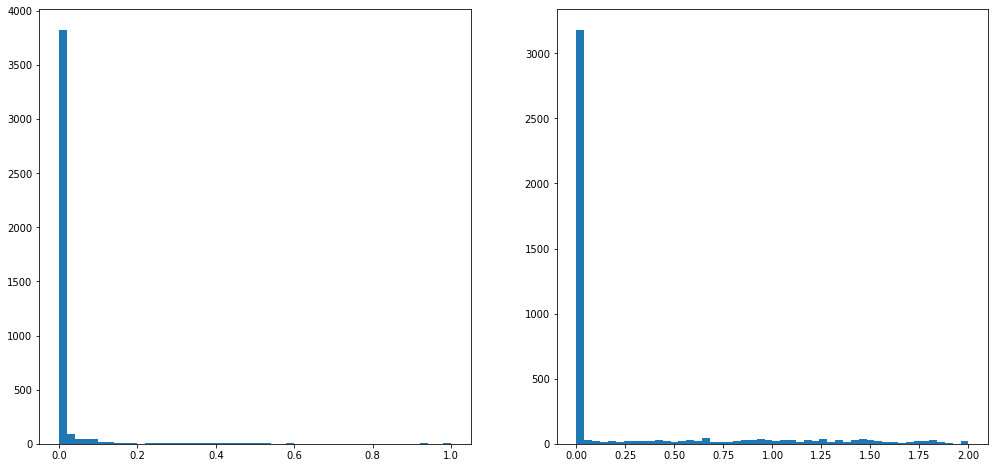

In [204]:
feat_idx = 190
plt.figure(figsize=(17,8))
plt.subplot(121)
plt.hist(X_train[:,0,feat_idx], bins=50)
plt.subplot(122)
plt.hist(0.1 * np.log10(1e10*X_train[:,0,feat_idx]**5 + 1e-10) + 1, bins=50)
plt.show()

170


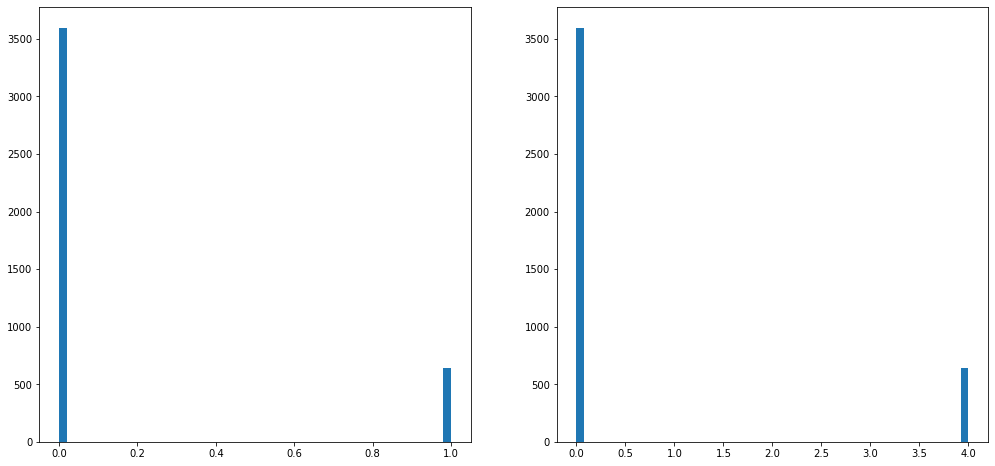

171


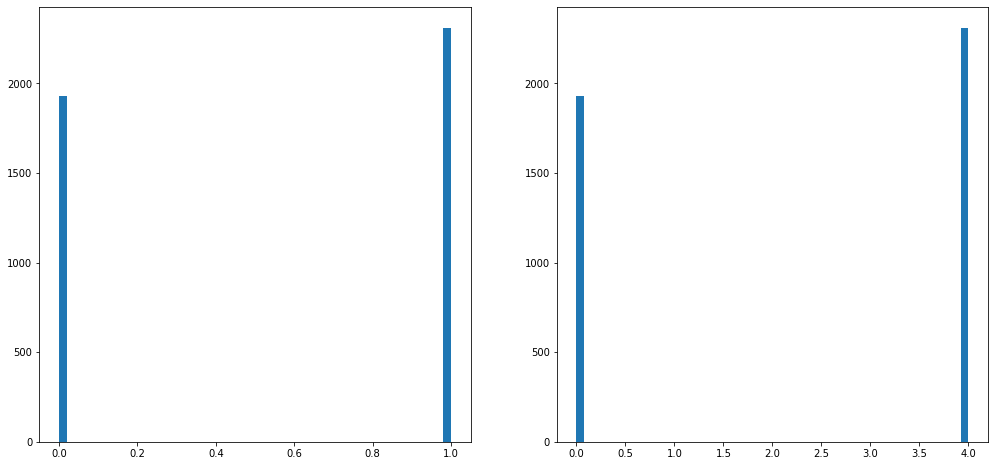

172


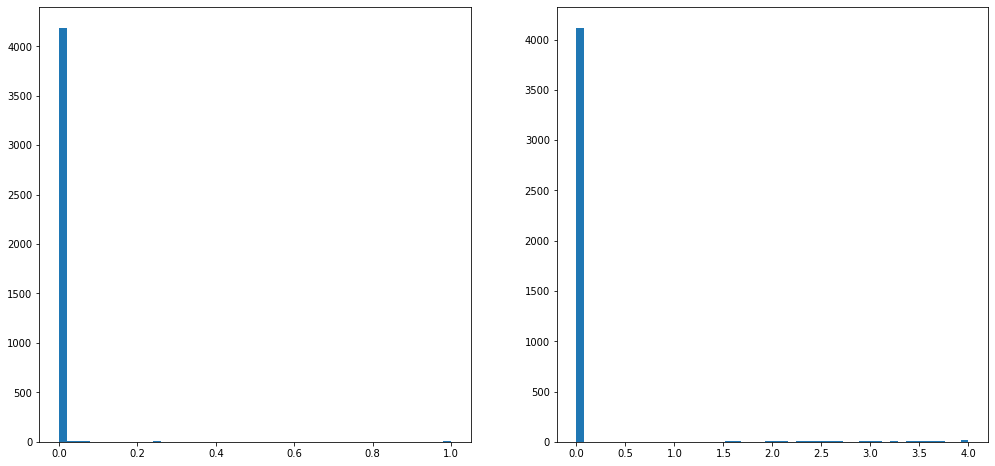

173


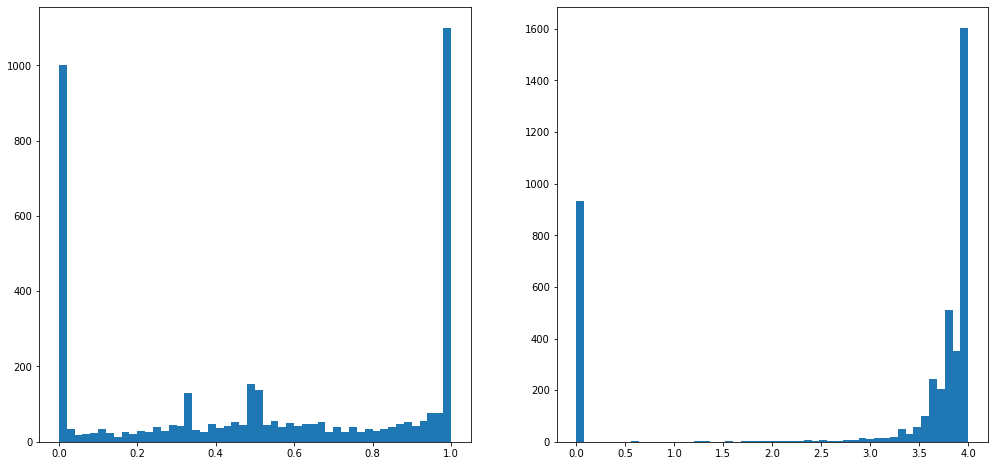

174


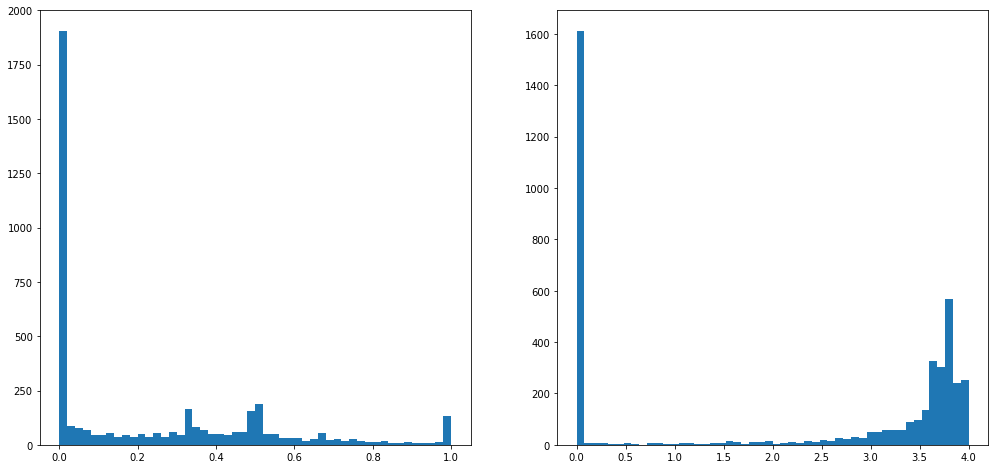

175


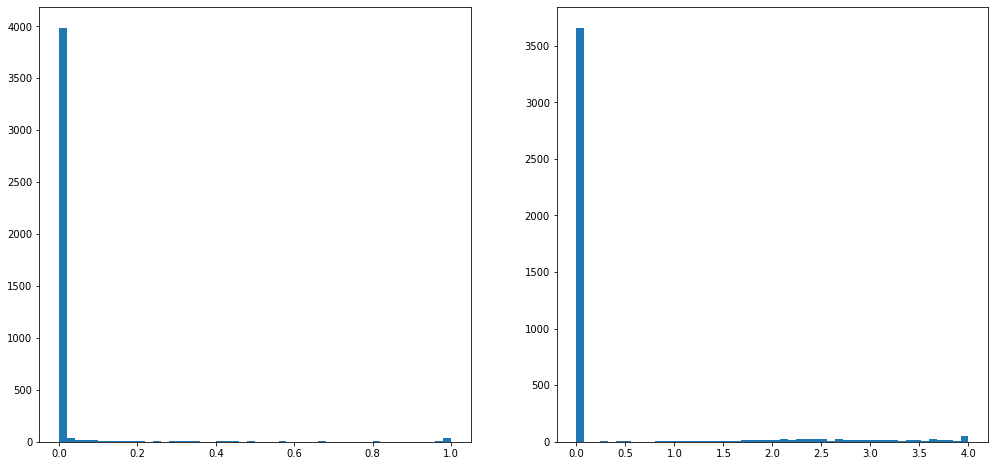

176


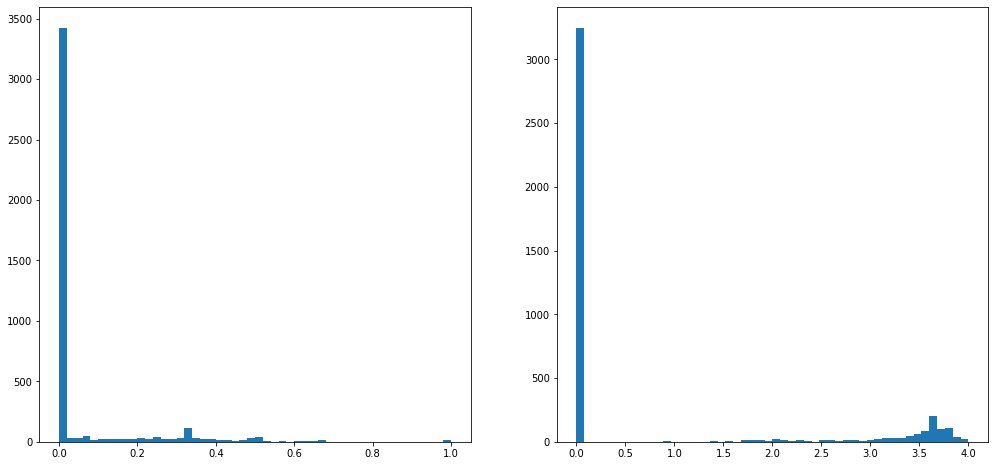

177


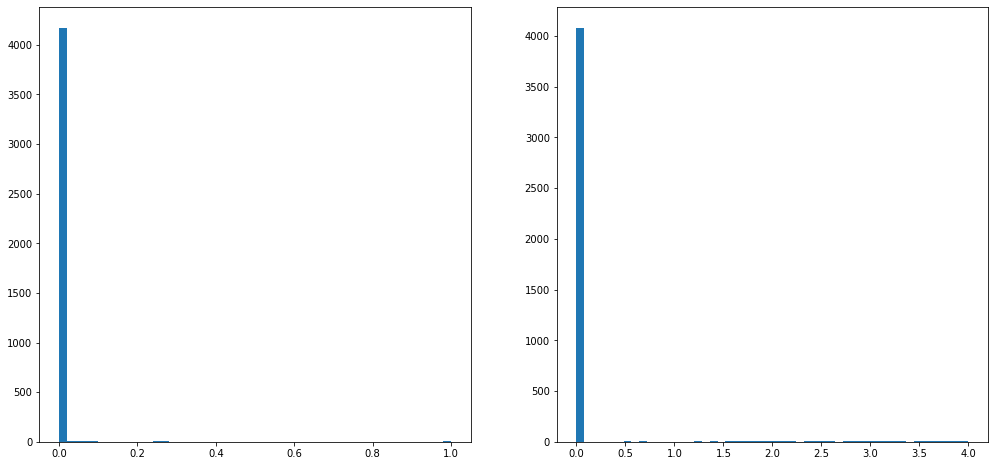

178


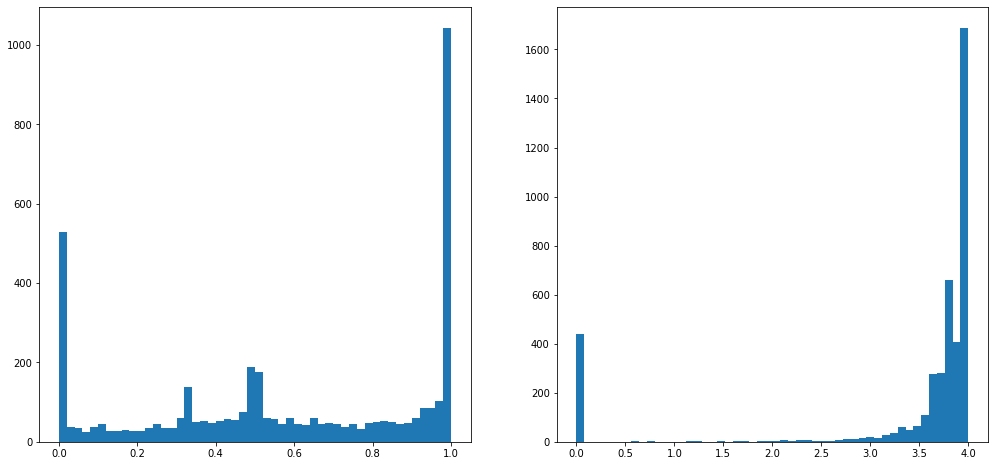

179


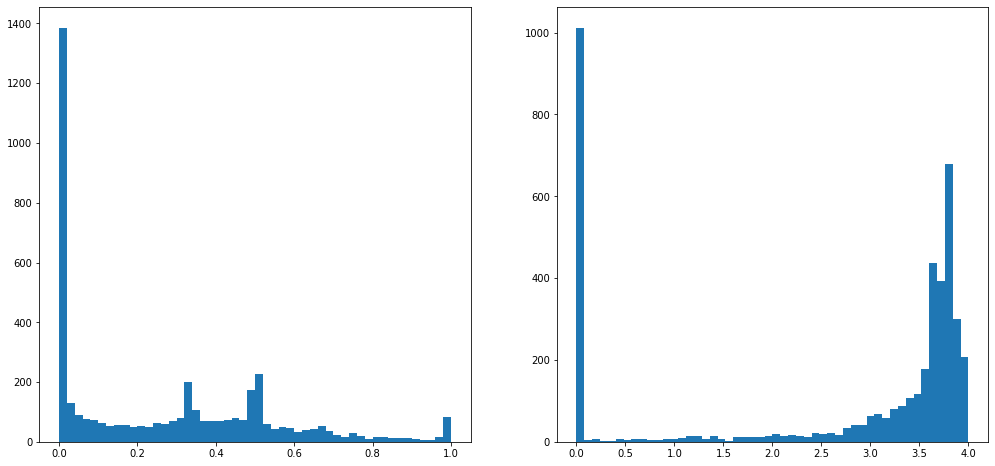

180


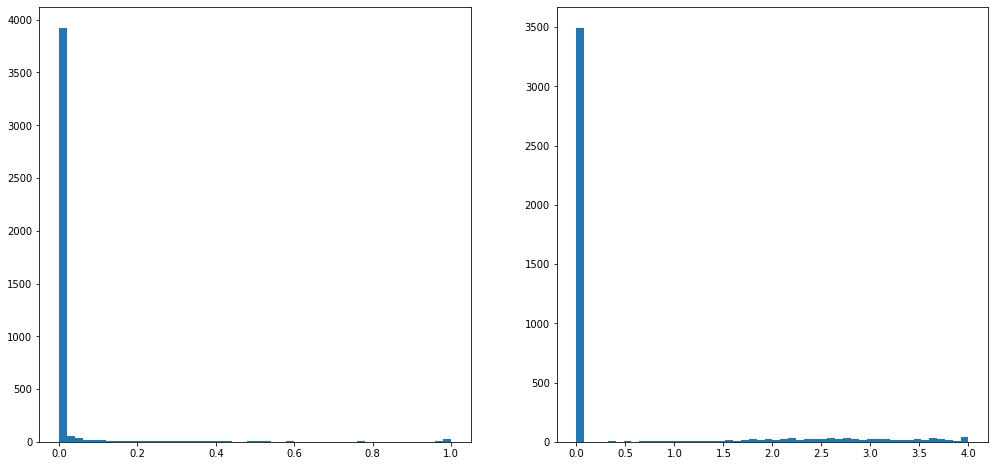

181


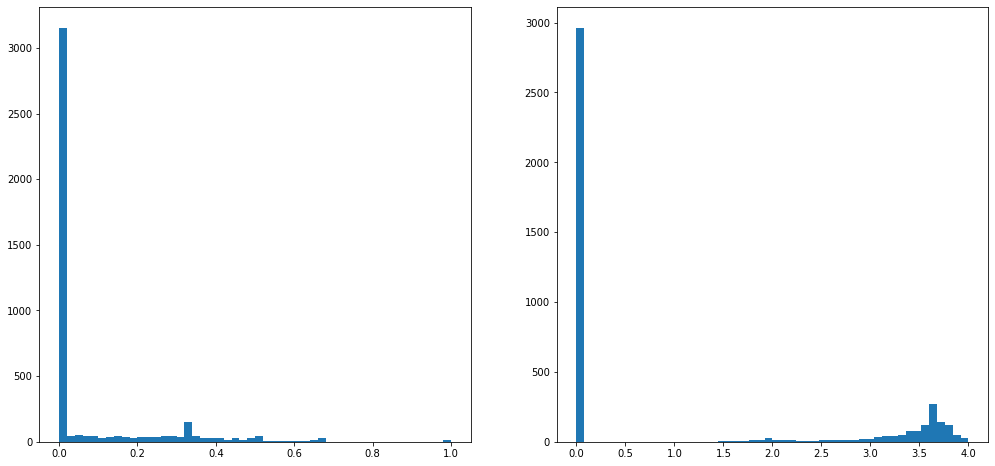

182


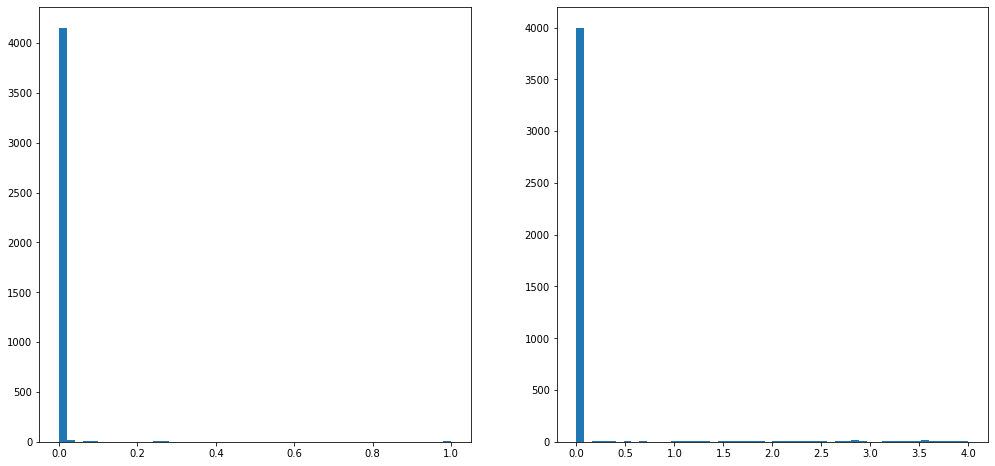

183


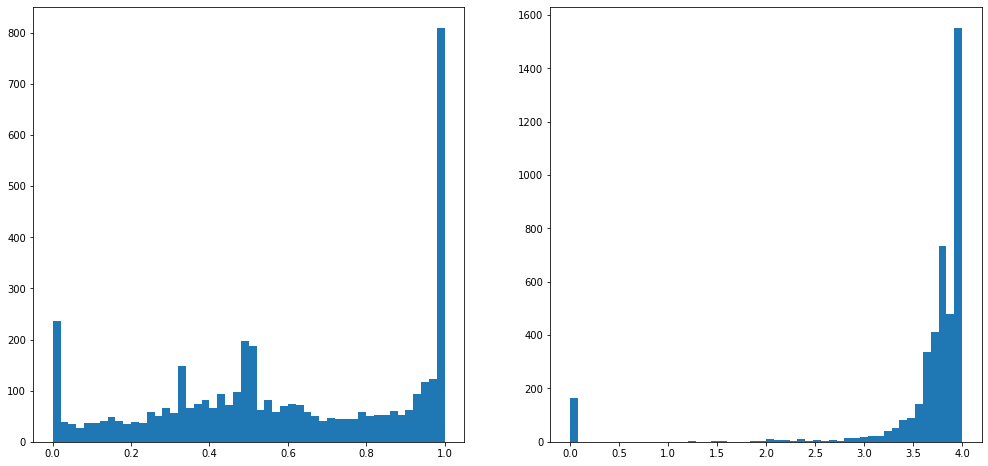

184


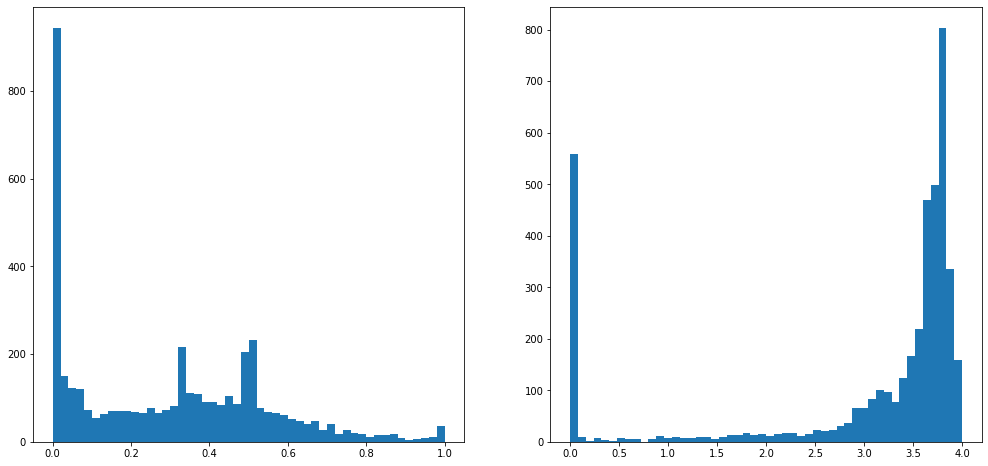

185


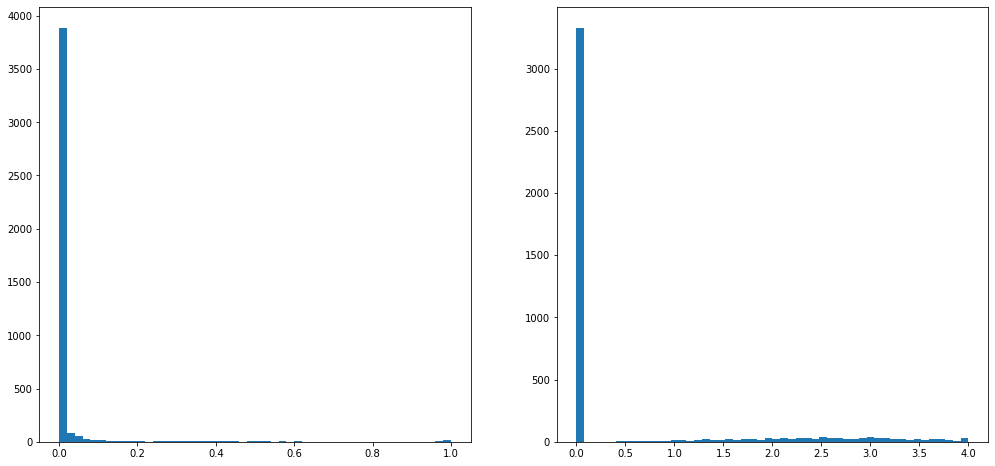

186


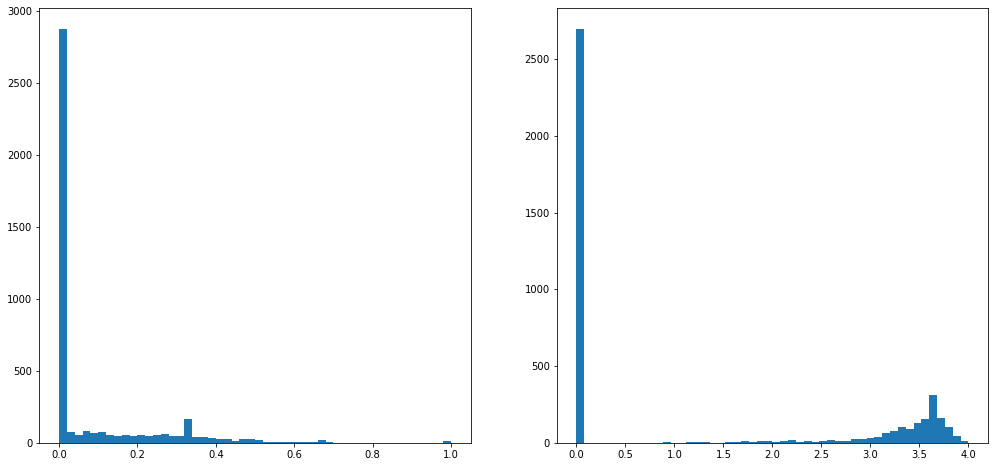

187


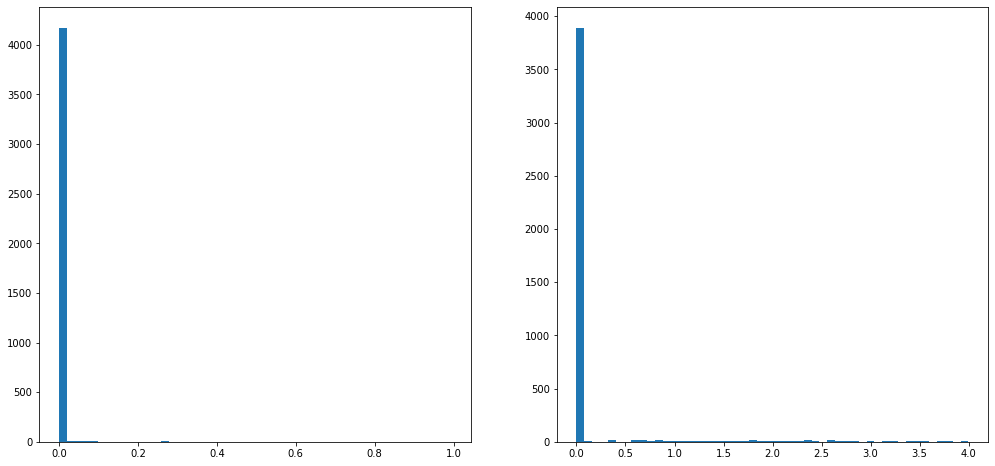

188


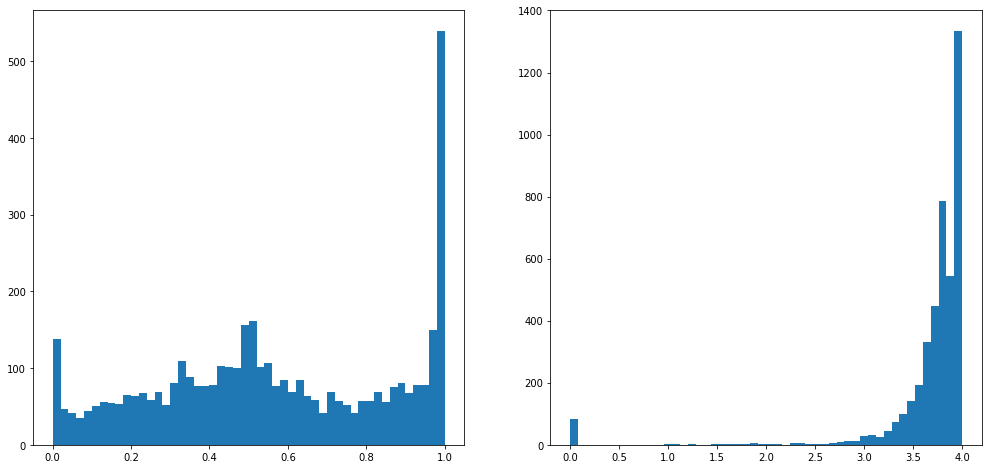

189


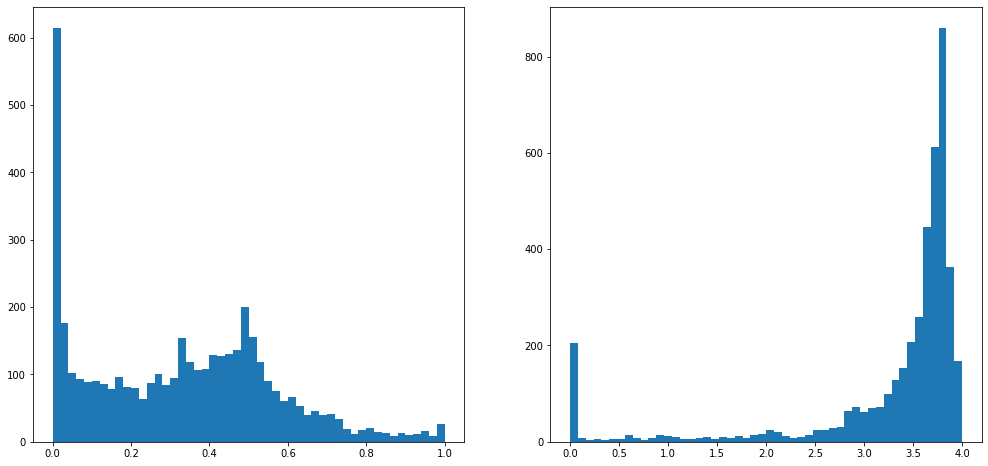

190


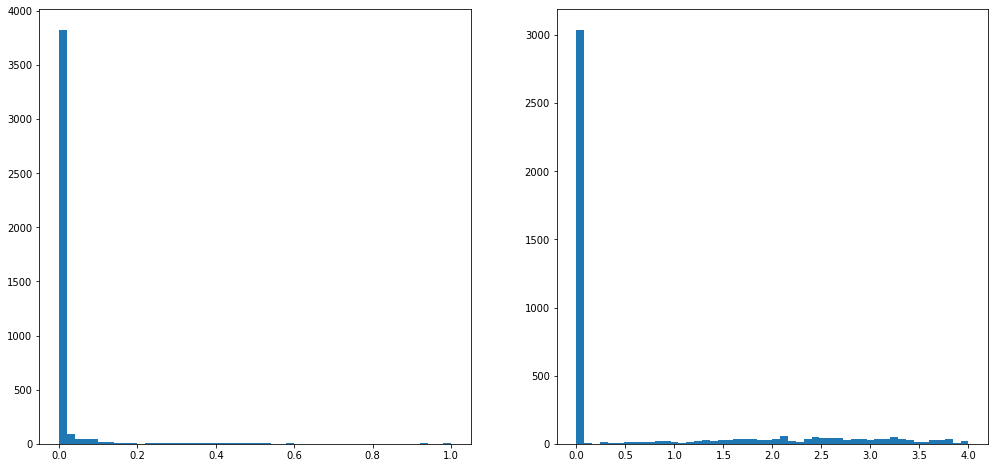

191


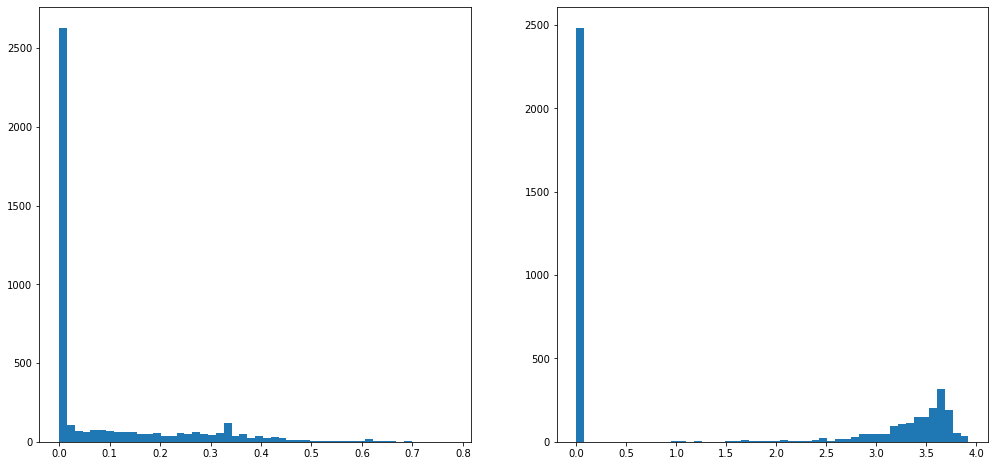

192


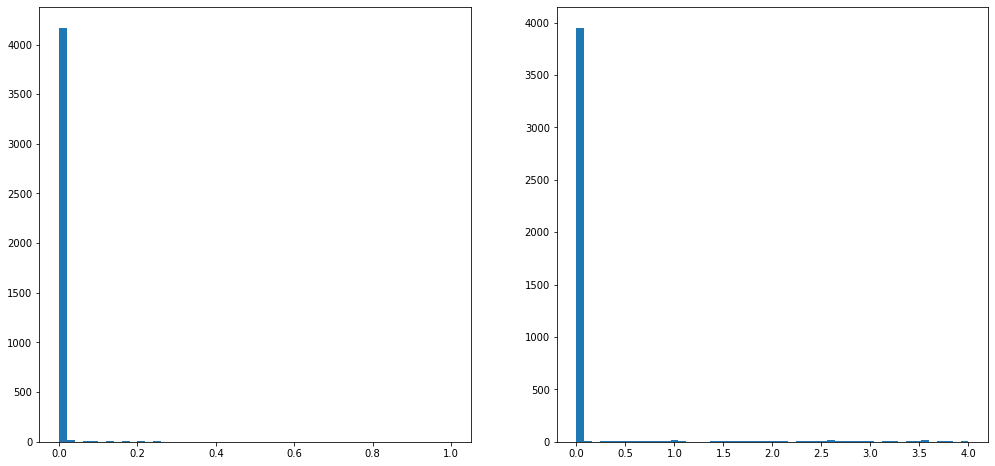

193


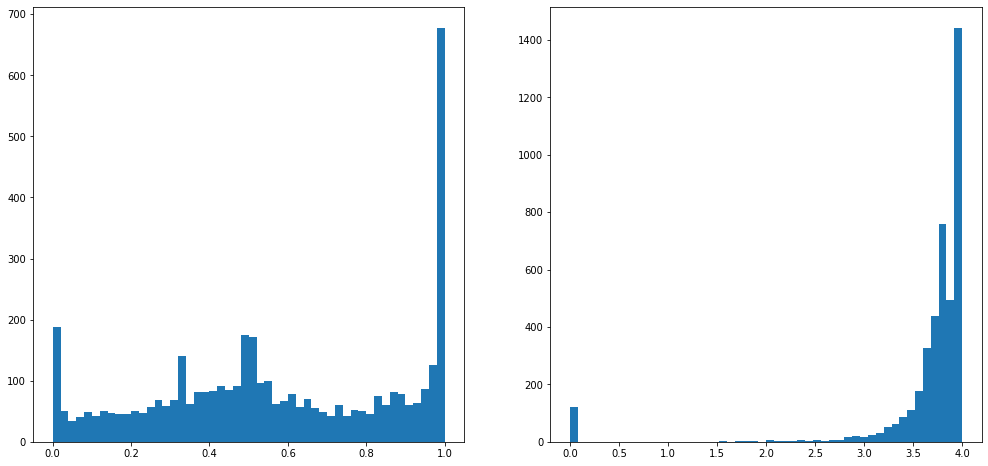

194


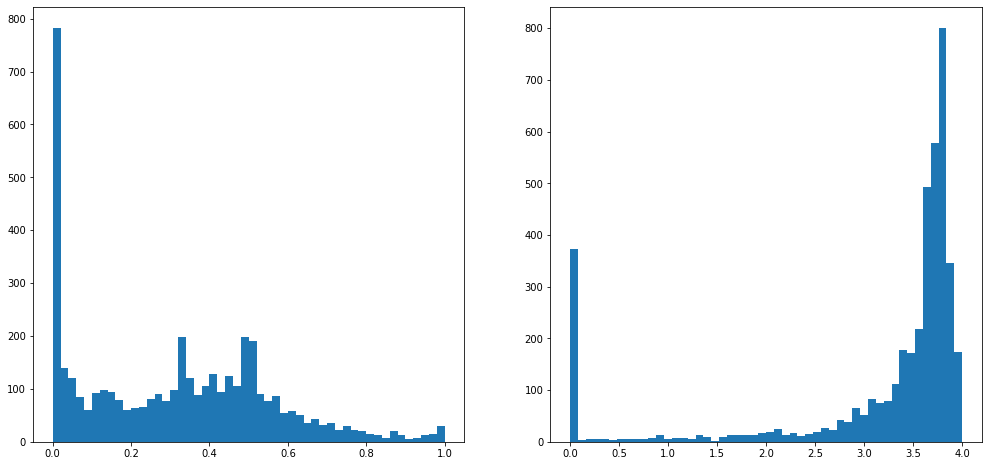

195


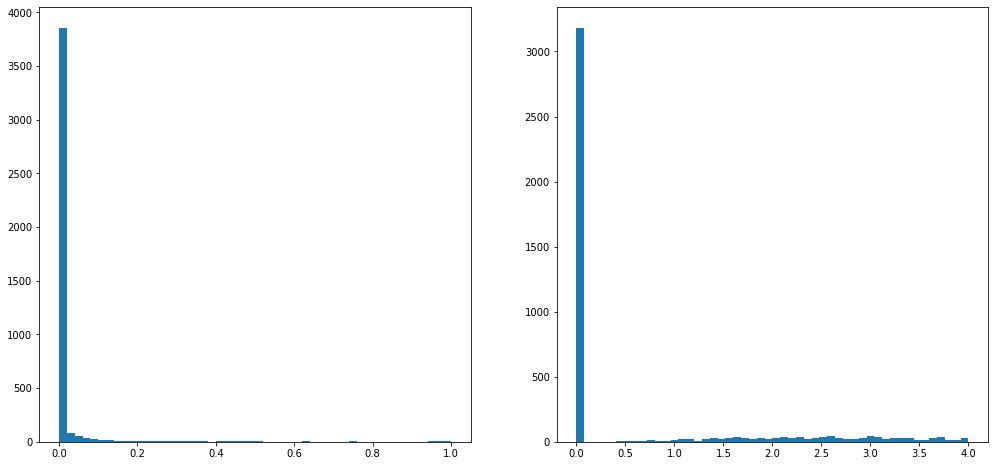

196


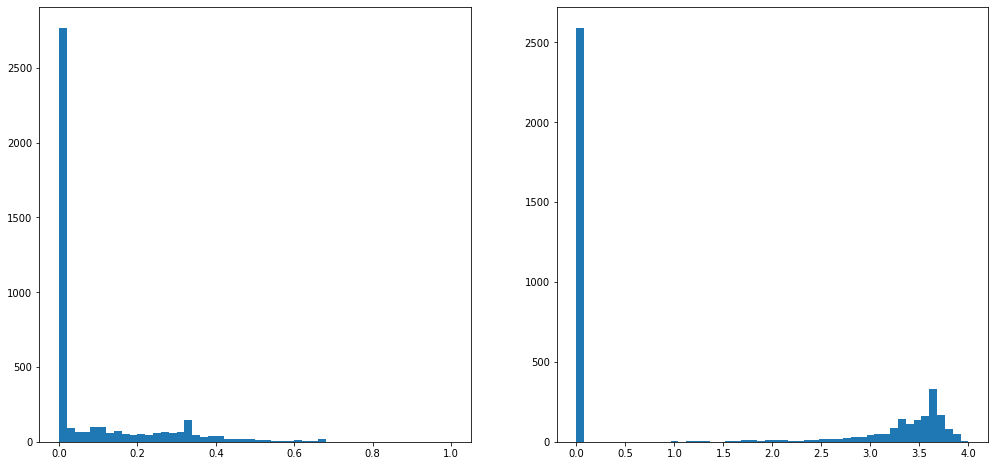

197


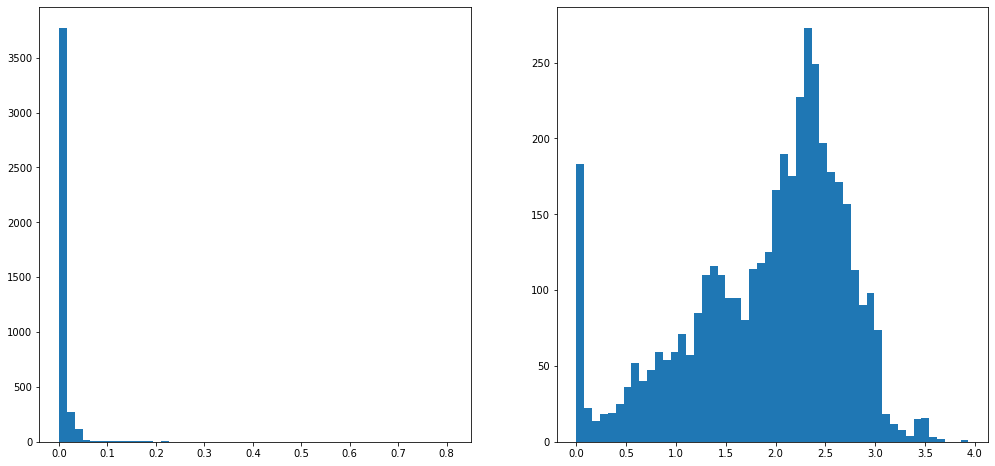

198


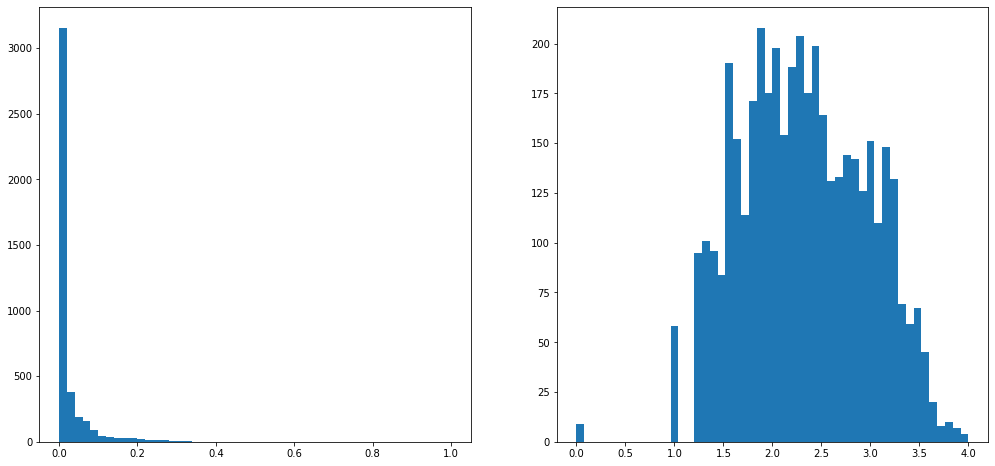

199


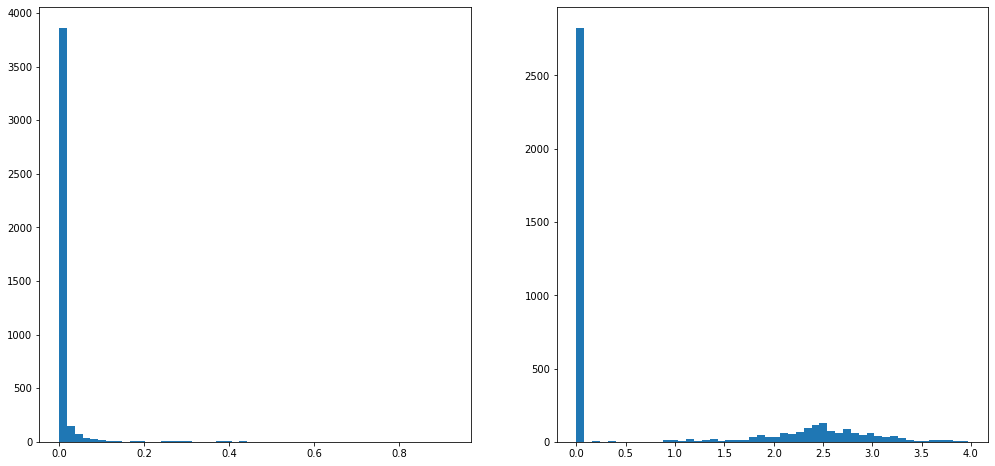

In [176]:
### Draw the feature distribution
# feat_idx = 288
for feat_idx in range(170, 200):
    print (feat_idx)
    plt.figure(figsize=(17,8))
    plt.subplot(121)
    plt.hist(X_train[:,0,feat_idx], bins=50)
    plt.subplot(122)
    plt.hist(0.1 * np.log10(1e30*X_train[:,0,feat_idx]**7 + 1e-10) + 1, bins=50)
    plt.show()

### Converting Numpy tensor into PyTorch tensor

In [212]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

train_data = []
for i in range(len(X_train)):
    train_data.append((X_train[i], y_train[i]))
    
test_data = []
for i in range(len(X_test)):
    test_data.append((X_test[i], y_test[i]))

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=train_batch_size)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=test_batch_size)

## Model Initialization

### Classifier / Focal Loss initialization
Notice that the dimensions per layer are recommended to set to a smaller value due to the risk of overfitting. 

In [217]:
classifier = ConvNet(fc_dims=[128, 64], in_dim=X_train.shape[2], out_dim=2).cuda()

focal_loss = FocalLoss2(alpha, gamma_pos, gamma_neg)
if optim_type == "adam":
    optim_clsfr = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), 
                             lr=learn_rate)
else:
    optim_clsfr = RangerLars(filter(lambda p: p.requires_grad, classifier.parameters()),
                             lr=learn_rate)

conv_dim = [646, 1292, 646]
fc_dim = [646/0.9, 128/0.8, 64/0.8, 2]


### VAT Loss initialization

In [218]:
vat_loss2 = VATLoss2(xi=vat_xi, eps_pos=vat_eps_pos, eps_neg=vat_eps_neg, ip=vat_ip)

## Training / Testing

In [219]:
def train(epoch, dataloader, clip_grad_norm=0, lambda_l1=1e-3):
    label_list = []
    pred_y_list = []
    
    clsf_loss_batch = []
    clsf_loss_pos_batch = []
    clsf_loss_neg_batch = []
    vat_batch = []
    for batch_idx, (data, target) in enumerate(dataloader):
        if data.size()[0] != dataloader.batch_size:
            continue
        data, target = Variable(data.cuda()), Variable(target.cuda())
        tmp = target.reshape(-1, 1)
        onehot_target = torch.cat([1-tmp, tmp], dim=1)
                
        #
        # Update classifier on real samples
        # ------------------------------------------------------------------------------------
        optim_clsfr.zero_grad()
        
        # VAT Loss
        vat_kld = vat_loss2(classifier, data.permute(0, 2, 1), target)     # for Conv1D
        
        # Focal Loss
        pred_y = classifier(data.permute(0, 2, 1)).squeeze(-1)
        clsf_loss, clsf_loss_pos, clsf_loss_neg = focal_loss(pred_y, onehot_target)
        
        # L1 Regularization Loss
        regularizer_loss_l1 = 0
        for param in classifier.parameters():
            regularizer_loss_l1 += torch.sum(torch.abs(param))
        
        # Total Loss
        loss = clsf_loss + 10 * vat_kld + lambda_l1 * regularizer_loss_l1
        
        loss.backward()
        
        # Gradient clipping
        if clip_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=clip_grad_norm)
        
        optim_clsfr.step()
        
        #
        # Record the losses
        # ------------------------------------------------------------------------------------
        pred_yy = torch.nn.functional.softmax(pred_y, dim=1)[:, 1]
        vat_batch.append(vat_kld)
        clsf_loss_batch.append(clsf_loss)
        if torch.sum(target) > 0:
            clsf_loss_pos_batch.append(clsf_loss_pos)
        clsf_loss_neg_batch.append(clsf_loss_neg)
        
        label_list += list(target.cpu().detach().numpy())
        pred_y_list += list(pred_yy.cpu().detach().numpy())
    
    vat_loss_avg = sum(vat_batch) / len(vat_batch)
    clsf_loss_avg = sum(clsf_loss_batch) / len(clsf_loss_batch)
    clsf_loss_pos_avg = sum(clsf_loss_pos_batch) / len(clsf_loss_pos_batch)
    clsf_loss_neg_avg = sum(clsf_loss_neg_batch) / len(clsf_loss_neg_batch)
    
    return np.array(label_list), np.array(pred_y_list), clsf_loss_avg, clsf_loss_pos_avg, clsf_loss_neg_avg, vat_loss_avg

In [250]:
def infer(dataloader):
    label_list = []
    pred_y_list = []   
    
    clsf_loss_batch = []
    clsf_loss_pos_batch = []
    clsf_loss_neg_batch = []
    for batch_idx, (data, target) in enumerate(dataloader):
        if data.size()[0] != dataloader.batch_size:
            continue
        data, target = Variable(data.cuda()), Variable(target.cuda())
        tmp = target.reshape(-1, 1)
        onehot_target = torch.cat([1-tmp, tmp], dim=1)
        
        # Update classifier
        pred_y = classifier(data.permute(0, 2, 1)).squeeze(-1)     # for Conv1D
        pred_y_softmax = torch.nn.functional.softmax(pred_y, dim=1)[:, 1]
        
        clsf_loss, clsf_loss_pos, clsf_loss_neg = focal_loss(pred_y, onehot_target)
        clsf_loss_batch.append(clsf_loss)
        if torch.sum(target) > 0:
            clsf_loss_pos_batch.append(clsf_loss_pos)
        clsf_loss_neg_batch.append(clsf_loss_neg)
        
        label_list += list(target.cpu().detach().numpy())
        pred_y_list += list(pred_y_softmax.cpu().detach().numpy())
    
    clsf_loss_avg = sum(clsf_loss_batch) / len(clsf_loss_batch)
    clsf_loss_pos_avg = sum(clsf_loss_pos_batch) / len(clsf_loss_pos_batch)
    clsf_loss_neg_avg = sum(clsf_loss_neg_batch) / len(clsf_loss_neg_batch)
    
    return np.array(label_list), np.array(pred_y_list), clsf_loss_avg, clsf_loss_pos_avg, clsf_loss_neg_avg

In [221]:
def evaluate(y_true, y_pred):
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return prec, recall, f1

In [252]:
print('Parameter Setting ----------------------------------------------------------------------')
print('Model = VAT + Conv1D')
print('conv1d use activation = {}'.format(True))
print('graph_emdeding = Heter_AutoEncoder')
print('alpha = {}'.format(alpha))
print('gamma_pos = {}'.format(gamma_pos))
print('gamma_neg = {}'.format(gamma_neg))
print('learn_rate = {}'.format(learn_rate))
print('train_batch_size = {}'.format(train_batch_size))
print('test_batch_size = {}'.format(test_batch_size))
print('max_epochs = {}'.format(max_epochs))
print('vat_xi = {}'.format(vat_xi))
print('vat_eps_pos = {}'.format(vat_eps_pos))
print('vat_eps_neg = {}'.format(vat_eps_neg))
print('vat_ip = {}'.format(vat_ip))
print('optim_type = {}'.format(optim_type))
print('weight_decay = {}'.format(weight_decay))
print('lambda_l1 = {}'.format(lambda_l1))
print('\n')

train_history_loss = []
train_history_auc = []
max_f1score = 0
for epoch in range(max_epochs):
    print('Epoch {} -------------------------------------------------------------------------'.format(epoch))
    
    #
    # Training
    # ------------------------------------------------------------------------------------
    classifier.train()
    label_train, pred_y_train, clsf_loss_train, clsf_loss_pos_train, \
        clsf_loss_neg_train, vat_loss_train = train(epoch, train_dataloader, 
                                                    clip_grad_norm=grad_clip, lambda_l1=lambda_l1)
    
    auc_train = roc_auc_score(label_train, pred_y_train)
    train_history_loss.append(clsf_loss_train)
    train_history_auc.append(auc_train)
    print('    Training => auc: {:.6f}, clsf_pos: {}, clsf_neg: {}, vat_loss: {}'.
          format(auc_train, clsf_loss_pos_train, clsf_loss_neg_train, vat_loss_train))
    thres = np.min(pred_y_train[label_train==1]) - 1e-6
    print("                Threshold is set to {}".format(thres))
    print("                Min. Probailities on train is {}".format(np.min(pred_y_train)))
    
    y_predict_bin = np.array(pred_y_train > thres, dtype=int)
    prec_train, recall_train, f1_train = evaluate(label_train, y_predict_bin)
    print('                prec: {:.4f}, rec: {:.4f}, F1score: {:.4f}'.
          format(prec_train, recall_train, f1_train))
    
    if epoch % 1 == 0:
        #
        # Testing
        # ------------------------------------------------------------------------------------        
        with torch.no_grad():
            classifier.eval()
            label_test, pred_y_test, clsf_loss_test, clsf_loss_pos_test, clsf_loss_neg_test = infer(test_dataloader)    
        
        auc = roc_auc_score(label_test, pred_y_test)
        
        print("            Min. Probailities on test set with label 1: {}".format(np.min(pred_y_test[label_test==1])))
        print("            Min. Probailities on test set             : {}".format(np.min(pred_y_test)))
        
        y_predict_bin = np.array(pred_y_test > thres, dtype=int)
        prec, recall, f1_bytrain = evaluate(label_test, y_predict_bin)
        print('    Testing by train ==> auc: {:.6f}, prec: {:.4f}, rec: {:.4f}, F1score: {:.4f}, clsf_loss: {}'.
              format(auc, prec, recall, f1_bytrain, clsf_loss_test))
        
        y_predict_bin = np.array(pred_y_test >= np.min(pred_y_test[label_test==1]), dtype=int)
        prec, recall, f1_bytest = evaluate(label_test, y_predict_bin)
        print('    Testing by test ==> auc: {:.6f}, prec: {:.4f}, rec: {:.4f}, F1score: {:.4f}, clsf_loss: {}'.
              format(auc, prec, recall, f1_bytest, clsf_loss_test))
        
        if clsf_loss_pos_train < 0.005 and f1_bytrain > max_f1score:
            max_f1score = f1_bytrain
            torch.save({'epoch': epoch,
                        'model_state_dict': classifier.state_dict(),
                        'optimizer_state_dict': optim_clsfr.state_dict(),
                        'loss': focal_loss,
                       }, 
                       '../../user_data/CloudMile/data/saved_models/' + \
                       'FeatEmbed-Conv1Dsmall_v2_eps{}{}_focal{}{}_{}_lr{}_epoch{}_Part2_{}'.
                       format(int(-math.log10(vat_eps_pos)), 
                              int(-math.log10(vat_eps_neg)), 
                              gamma_pos, gamma_neg, 
                              optim_type, int(-math.log10(learn_rate)), max_epochs, f1_bytrain))


Parameter Setting ----------------------------------------------------------------------
Model = VAT + Conv1D
conv1d use activation = True
graph_emdeding = Heter_AutoEncoder
alpha = 1
gamma_pos = 6
gamma_neg = 2
learn_rate = 0.0001
train_batch_size = 128
test_batch_size = 32
max_epochs = 400
vat_xi = 1e-06
vat_eps_pos = 100.0
vat_eps_neg = 0.1
vat_ip = 1
optim_type = rlars
weight_decay = 0
lambda_l1 = 0


Epoch 0 -------------------------------------------------------------------------
    Training => auc: 1.000000, clsf_pos: 0.0048776171170175076, clsf_neg: 0.012627321295440197, vat_loss: 0.0003767216403502971
                Threshold is set to 0.45484386222267154
                Min. Probailities on train is 0.305832177400589
                prec: 1.0000, rec: 1.0000, F1score: 1.0000
            Min. Probailities on test set with label 1: 0.47109854221343994
            Min. Probailities on test set             : 0.3718127906322479
    Testing by train ==> auc: 0.976798, prec: 0.043

            Min. Probailities on test set with label 1: 0.4710876941680908
            Min. Probailities on test set             : 0.37184804677963257
    Testing by train ==> auc: 0.969372, prec: 0.0492, rec: 1.0000, F1score: 0.0938, clsf_loss: 0.02741476520895958
    Testing by test ==> auc: 0.969372, prec: 0.0957, rec: 1.0000, F1score: 0.1748, clsf_loss: 0.02741476520895958
Epoch 11 -------------------------------------------------------------------------
    Training => auc: 0.999865, clsf_pos: 0.004772593267261982, clsf_neg: 0.012598419561982155, vat_loss: 0.00041247709305025637
                Threshold is set to 0.4549405707588196
                Min. Probailities on train is 0.30536243319511414
                prec: 0.9806, rec: 1.0000, F1score: 0.9902
            Min. Probailities on test set with label 1: 0.46992090344429016
            Min. Probailities on test set             : 0.3701085150241852
    Testing by train ==> auc: 0.977398, prec: 0.0563, rec: 1.0000, F1score: 0.

            Min. Probailities on test set with label 1: 0.4705255329608917
            Min. Probailities on test set             : 0.36729827523231506
    Testing by train ==> auc: 0.974172, prec: 0.0659, rec: 1.0000, F1score: 0.1237, clsf_loss: 0.0231198500841856
    Testing by test ==> auc: 0.974172, prec: 0.0973, rec: 1.0000, F1score: 0.1773, clsf_loss: 0.0231198500841856
Epoch 22 -------------------------------------------------------------------------
    Training => auc: 0.999987, clsf_pos: 0.004873449914157391, clsf_neg: 0.012625806964933872, vat_loss: 0.0004037352337036282
                Threshold is set to 0.45611671941185
                Min. Probailities on train is 0.31324389576911926
                prec: 0.9903, rec: 1.0000, F1score: 0.9951
            Min. Probailities on test set with label 1: 0.4716452956199646
            Min. Probailities on test set             : 0.3688685894012451
    Testing by train ==> auc: 0.977460, prec: 0.0579, rec: 1.0000, F1score: 0.1094, 

            Min. Probailities on test set with label 1: 0.46969082951545715
            Min. Probailities on test set             : 0.3675585091114044
    Testing by train ==> auc: 0.981998, prec: 0.0744, rec: 1.0000, F1score: 0.1385, clsf_loss: 0.021153340116143227
    Testing by test ==> auc: 0.981998, prec: 0.1034, rec: 1.0000, F1score: 0.1875, clsf_loss: 0.021153340116143227
Epoch 33 -------------------------------------------------------------------------
    Training => auc: 0.999715, clsf_pos: 0.0047034756280481815, clsf_neg: 0.012417356483638287, vat_loss: 0.0004016199382022023
                Threshold is set to 0.4522829188575745
                Min. Probailities on train is 0.3092871308326721
                prec: 0.9806, rec: 1.0000, F1score: 0.9902
            Min. Probailities on test set with label 1: 0.47272396087646484
            Min. Probailities on test set             : 0.3713642358779907
    Testing by train ==> auc: 0.973072, prec: 0.0504, rec: 1.0000, F1score: 0

            Min. Probailities on test set with label 1: 0.4736897051334381
            Min. Probailities on test set             : 0.37069523334503174
    Testing by train ==> auc: 0.962696, prec: 0.0319, rec: 1.0000, F1score: 0.0619, clsf_loss: 0.03631863743066788
    Testing by test ==> auc: 0.962696, prec: 0.0978, rec: 1.0000, F1score: 0.1782, clsf_loss: 0.03631863743066788
Epoch 44 -------------------------------------------------------------------------
    Training => auc: 0.999685, clsf_pos: 0.004784895572811365, clsf_neg: 0.0123846884816885, vat_loss: 0.00038633361691609025
                Threshold is set to 0.4565054907073975
                Min. Probailities on train is 0.30282291769981384
                prec: 0.9902, rec: 1.0000, F1score: 0.9951
            Min. Probailities on test set with label 1: 0.4735760986804962
            Min. Probailities on test set             : 0.36679166555404663
    Testing by train ==> auc: 0.973235, prec: 0.0534, rec: 1.0000, F1score: 0.10

            Min. Probailities on test set with label 1: 0.45938557386398315
            Min. Probailities on test set             : 0.3590717613697052
    Testing by train ==> auc: 0.983298, prec: 0.0918, rec: 1.0000, F1score: 0.1682, clsf_loss: 0.013679738156497478
    Testing by test ==> auc: 0.983298, prec: 0.1059, rec: 1.0000, F1score: 0.1915, clsf_loss: 0.013679738156497478
Epoch 55 -------------------------------------------------------------------------
    Training => auc: 1.000000, clsf_pos: 0.004622192587703466, clsf_neg: 0.012092788703739643, vat_loss: 0.0003480741288512945
                Threshold is set to 0.45236049430274966
                Min. Probailities on train is 0.3046858012676239
                prec: 1.0000, rec: 1.0000, F1score: 1.0000
            Min. Probailities on test set with label 1: 0.45467475056648254
            Min. Probailities on test set             : 0.35845544934272766
    Testing by train ==> auc: 0.983823, prec: 0.0994, rec: 1.0000, F1score: 

            Min. Probailities on test set with label 1: 0.4661172330379486
            Min. Probailities on test set             : 0.3574042022228241
    Testing by train ==> auc: 0.981048, prec: 0.0756, rec: 1.0000, F1score: 0.1406, clsf_loss: 0.016061317175626755
    Testing by test ==> auc: 0.981048, prec: 0.0984, rec: 1.0000, F1score: 0.1791, clsf_loss: 0.016061317175626755
Epoch 66 -------------------------------------------------------------------------
    Training => auc: 1.000000, clsf_pos: 0.004628313705325127, clsf_neg: 0.012317115440964699, vat_loss: 0.000368756998796016
                Threshold is set to 0.45377258794212344
                Min. Probailities on train is 0.313636839389801
                prec: 1.0000, rec: 1.0000, F1score: 1.0000
            Min. Probailities on test set with label 1: 0.4705296456813812
            Min. Probailities on test set             : 0.3592057228088379
    Testing by train ==> auc: 0.976773, prec: 0.0698, rec: 1.0000, F1score: 0.130

            Min. Probailities on test set with label 1: 0.47293415665626526
            Min. Probailities on test set             : 0.36071255803108215
    Testing by train ==> auc: 0.974197, prec: 0.0726, rec: 1.0000, F1score: 0.1353, clsf_loss: 0.019358476623892784
    Testing by test ==> auc: 0.974197, prec: 0.1029, rec: 1.0000, F1score: 0.1865, clsf_loss: 0.019358476623892784
Epoch 77 -------------------------------------------------------------------------
    Training => auc: 1.000000, clsf_pos: 0.0043875728733837605, clsf_neg: 0.011926930397748947, vat_loss: 0.00035628245677798986
                Threshold is set to 0.4621628655662537
                Min. Probailities on train is 0.29959630966186523
                prec: 1.0000, rec: 1.0000, F1score: 1.0000
            Min. Probailities on test set with label 1: 0.47122207283973694
            Min. Probailities on test set             : 0.3615216612815857
    Testing by train ==> auc: 0.978073, prec: 0.0783, rec: 1.0000, F1score

            Min. Probailities on test set with label 1: 0.4728914797306061
            Min. Probailities on test set             : 0.36165064573287964
    Testing by train ==> auc: 0.980748, prec: 0.0783, rec: 1.0000, F1score: 0.1452, clsf_loss: 0.01750343292951584
    Testing by test ==> auc: 0.980748, prec: 0.1104, rec: 1.0000, F1score: 0.1989, clsf_loss: 0.01750343292951584
Epoch 88 -------------------------------------------------------------------------
    Training => auc: 1.000000, clsf_pos: 0.004403925035148859, clsf_neg: 0.011856642551720142, vat_loss: 0.0003150923876091838
                Threshold is set to 0.4544185830821991
                Min. Probailities on train is 0.30455508828163147
                prec: 1.0000, rec: 1.0000, F1score: 1.0000
            Min. Probailities on test set with label 1: 0.46448442339897156
            Min. Probailities on test set             : 0.35856786370277405
    Testing by train ==> auc: 0.981348, prec: 0.0942, rec: 1.0000, F1score: 0.

            Min. Probailities on test set with label 1: 0.4726434051990509
            Min. Probailities on test set             : 0.36317890882492065
    Testing by train ==> auc: 0.975148, prec: 0.0687, rec: 1.0000, F1score: 0.1286, clsf_loss: 0.019746964797377586
    Testing by test ==> auc: 0.975148, prec: 0.0984, rec: 1.0000, F1score: 0.1791, clsf_loss: 0.019746964797377586
Epoch 99 -------------------------------------------------------------------------
    Training => auc: 1.000000, clsf_pos: 0.004423059988766909, clsf_neg: 0.011921236291527748, vat_loss: 0.000401397846871987
                Threshold is set to 0.45683620707893374
                Min. Probailities on train is 0.31017571687698364
                prec: 1.0000, rec: 1.0000, F1score: 1.0000
            Min. Probailities on test set with label 1: 0.4753718078136444
            Min. Probailities on test set             : 0.3642335534095764
    Testing by train ==> auc: 0.967272, prec: 0.0659, rec: 1.0000, F1score: 0.

            Min. Probailities on test set with label 1: 0.46473830938339233
            Min. Probailities on test set             : 0.3605159819126129
    Testing by train ==> auc: 0.978610, prec: 0.0837, rec: 1.0000, F1score: 0.1545, clsf_loss: 0.015017720870673656
    Testing by test ==> auc: 0.978610, prec: 0.1034, rec: 1.0000, F1score: 0.1875, clsf_loss: 0.015017720870673656
Epoch 110 -------------------------------------------------------------------------
    Training => auc: 0.999986, clsf_pos: 0.004534517414867878, clsf_neg: 0.01184209156781435, vat_loss: 0.00034904605126939714
                Threshold is set to 0.4493442310562134
                Min. Probailities on train is 0.30466917157173157
                prec: 0.9901, rec: 1.0000, F1score: 0.9950
            Min. Probailities on test set with label 1: 0.47164538502693176
            Min. Probailities on test set             : 0.36145901679992676
    Testing by train ==> auc: 0.974410, prec: 0.0750, rec: 1.0000, F1score:

KeyboardInterrupt: 

In [243]:
max_f1score = f1
torch.save({'epoch': epoch,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optim_clsfr.state_dict(),
            'loss': focal_loss,
           }, 
           '../../user_data/CloudMile/data/saved_models/' + \
           'ResaledFeatEmbed-Conv1D_eps{}{}_focal{}{}_{}_lr{}_epoch{}_Part2_{}'.
           format(int(-math.log10(vat_eps_pos)), 
                  int(-math.log10(vat_eps_neg)), 
                  gamma_pos, gamma_neg, 
                  optim_type, int(-math.log10(learn_rate)), max_epochs, f1))

In [ ]:
results = {(2019, 6): {'train': {'auc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1score': 1.0},
                       'test': {'auc': 1.0,
                                'prec1': 0.3333, 'rec1': 1.0000, 'f1score1': 0.5000,
                                'prec2': 1.0, 'rec2': 1.0, 'f1score2': 1.0},
                      },
           (2019, 5): {'train': {'auc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1score': 1.0},
                       'test': {'auc': 1.0,
                                'prec1': 0.3333, 'rec1': 1.0000, 'f1score1': 0.5000,
                                'prec2': 1.0, 'rec2': 1.0, 'f1score2': 1.0},
                      },